## Importación de Librerías
Importamos la lista de librerías que vamos a utilizar, y que ya están listadas en otro archivo:

In [ ]:
%run ".\\00. Importación de Librerías\\Librerias_para_importar.ipynb"

## Definición de funciones
Importamos las funciones definidas en otro archivo:

In [ ]:
%run ".\\00. Definición de funciones\\Funciones_definidas.ipynb"

# **MODELO PARA COMPRAR:**

Este modelo predictivo indicará los momentos óptimos para comprar las acciones, a partir de predicciones de subas en las cotizaciones futuras.

## Preparación de los Datos:

In [3]:
# CARGA DE DATOS
data =  pd.read_csv(".\\2. Preprocesado de Datos\\Datos_Completos_Preprocesados.csv")
data ["fecha"] = pd.to_datetime(data["fecha"], dayfirst=True)  # Volvemos a colocar el formato datetime64 a la columna 'fecha'.
data = data.sort_values(by=['fecha'])  # Ordenamos las columnas del DataFrame por fecha

In [4]:
# Cargamos las listas de las variables ya definidas durante el Preprocesado de Datos:

with open(".\\2. Preprocesado de Datos\\variables_target_intradiarias.pickle", 'rb') as archivo:
    variables_target_intradiarias = pickle.load(archivo)
    
with open(".\\2. Preprocesado de Datos\\variables_target_de_largo_plazo.pickle", 'rb') as archivo:
    variables_target_de_largo_plazo = pickle.load(archivo)  
    
with open(".\\2. Preprocesado de Datos\\variables_independientes.pickle", 'rb') as archivo:
    variables_independientes = pickle.load(archivo)    
    
with open(".\\2. Preprocesado de Datos\\variables_dependientes.pickle", 'rb') as archivo:
    variables_dependientes = pickle.load(archivo)    
    
# Actualizamos la lista de variables dependientes para conservar únicamente aquellas que realmente están presentes en este DataFrame:
variables_independientes = variables_independientes.intersection( set(data.columns) ) 
variables_dependientes = variables_dependientes.intersection( set(data.columns) ) 
variables_target_intradiarias = variables_target_intradiarias.intersection( set(data.columns) ) 
variables_target_de_largo_plazo = variables_target_de_largo_plazo.intersection( set(data.columns) ) 

# Identificamos las variables target binarias:
variables_target_de_largo_plazo_binarias = set ( data[list(variables_target_de_largo_plazo)].columns [data[list(variables_target_de_largo_plazo)].isin([0,1]).all()] )
variables_target_intradiarias_binarias = set ( data[list(variables_target_intradiarias)].columns [data[list(variables_target_intradiarias)].isin([0,1]).all()] )

variables_target_de_largo_plazo_binarias_de_compra = []
variables_target_de_largo_plazo_binarias_de_venta = []

for variable_target in variables_target_de_largo_plazo_binarias:
    if variable_target [9] == "1":
        variables_target_de_largo_plazo_binarias_de_compra.append(variable_target)
    if variable_target [9] == "0":
        variables_target_de_largo_plazo_binarias_de_venta.append(variable_target)

In [5]:
# Creamos un DataFrame con las variables dependientes (targets), las variables independientes (predictors) y la variable "fecha" que
# nos servirá para separar el DataSet en Training y Test (más adelante eliminaremos la variable "fecha" de este nuevo DataFrame):
df_variables = data[ list(variables_dependientes.union(variables_independientes).union(list(["fecha"]))) ].copy()

# Creamos un DataFrame basado en una copia del anterior, para luego normalizarlo:
df_variables_normalizadas = df_variables.copy()
flag_normalizado = "Ninguno"

In [6]:
# Definimos la variable objetivo:
variable_target = "umbral_=_1.05_maximo_de_high_en_proximos_10_dias/open(t)"
variable_target_de_compra = variable_target
chequeo_ausencia_de_variables_futuras_en_las_variables_independientes(variables_independientes)

In [8]:
# Separamos el DataSet en Train y Test:
# A partir de un ratio (porcentaje) de la cantidad de datos a separar en Train y Test, calculamos la fecha que coincide con ese
# ratio y finalmente hacemos la separación de los datos en base a esa fecha, para así evitar que haya una fecha que esté presente
# tanto en el DataSet de Train como en el de Test:

ratio_de_division_train_test = 0.8
limite_o_division = int(df_variables_normalizadas.shape[0] * ratio_de_division_train_test) 
fecha_limite_o_division = df_variables_normalizadas.iloc[limite_o_division].fecha

data_train = df_variables_normalizadas [df_variables_normalizadas.fecha <= fecha_limite_o_division]
data_test = df_variables_normalizadas [df_variables_normalizadas.fecha > fecha_limite_o_division]

train_n = data_train.shape[0]
test_n = data_test.shape[0]

print('Train size: {}  //  {} %'.format(train_n, int(train_n / (train_n + test_n)*100)))
print('Test size: {}  //  {} %'.format(test_n, int(test_n / (train_n + test_n)*100)))

x_train = data_train [list (variables_independientes)]
x_test = data_test [list (variables_independientes)]
y_train = data_train [variable_target]
y_test = data_test [variable_target]

# Verificamos que todas las filas del DataFrame "df_variables_normalizadas" hayan sido asignadas al DataTrain o al DataTest:
if (data_train.shape[0] + data_test.shape[0]) != df_variables_normalizadas.shape[0]:
    print("\n ATENCIÓN: NO coincide el tamaño del 'df_variables_normalizadas' con la suma del Train size y el Test size.")
    
# Eliminamos la variable "fecha" de los DataFrames "df_variables", "df_variables_normalizadas" y demás:
df_variables = df_variables.drop(['fecha'], axis=1)
df_variables_normalizadas = df_variables_normalizadas.drop(['fecha'], axis=1)
data_train = data_train.drop(['fecha'], axis=1)
data_test = data_test.drop(['fecha'], axis=1)

Train size: 53976  //  80 %
Test size: 13483  //  19 %


## Modelo LightGBM :


In [10]:
# ENTRENAMIENTO
modelo = lightgbm.LGBMClassifier (objective = 'binary', learning_rate = 0.05)
modelo.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=2, objective='binary')

In [ ]:
# PREDICCIONES:
y_pred_con_probabilidades = modelo.predict_proba(x_test)
y_pred_con_probabilidad_que_sea_positivo = y_pred_con_probabilidades[:,1]

# Para establecer el Umbral de Clasificación (umbral de corte) entre las predicciones positivas y las negativas, tenemos 2 opciones: 
#  - Establecemos directamente el 'umbral_de_clasificacion' (y no sabremos a priori qué porcentaje de predicciones positivas obtendremos)
#  - Establecemos el 'porcentaje_buscado_de_predicciones_positivas' y a partir de ahí calculamos el 'umbral_de_clasificacion' que nos dará dicho porcentaje.

umbral_de_clasificacion = None
porcentaje_buscado_de_predicciones_positivas = 0.15  #(este valor debe estar expresado entre 0 y 1)
umbral_de_clasificacion = np.quantile(y_pred_con_probabilidad_que_sea_positivo, 1-(porcentaje_buscado_de_predicciones_positivas), interpolation='lower')

y_pred = probabilidades_a_clases(y_pred_con_probabilidades, umbral_de_clasificacion)
y_pred_de_compra = y_pred
y_pred_en_formato_serie = pd.Series( data = y_pred, index = y_test.index)

## Resultados del modelo :

In [ ]:
# Graficamos el 'Plot Importance':
from lightgbm import plot_importance
plt.style.use("default")
plt.rcParams['figure.figsize'] = (6,10)
lightgbm.plot_importance(modelo);

In [ ]:
# Graficamos el 'y_pred_con_probabilidad_que_sea_positivo', es decir los valores predichos por el modelo:
graficar_y_pred_con_probabilidad_que_sea_positivo (data, y_test, y_pred_con_probabilidad_que_sea_positivo, umbral_de_clasificacion,
                                                   marcar_casos_positivos_y_negativos = "no")

In [ ]:
# Graficamos el 'y_pred_con_probabilidad_que_sea_positivo' para una acción en particular:

graficar_y_pred_con_probabilidad_que_sea_positivo_para_una_accion_particular_con_cotizacion (data, "ALUA", y_test, 
                                                                                             y_pred_con_probabilidad_que_sea_positivo, 
                                                                                             variable_target)

In [ ]:
# Graficamos el 'y_pred_con_probabilidad_que_sea_positivo' para una acción en particular:

graficar_y_pred_con_probabilidad_que_sea_positivo_para_una_accion_particular (data, "ALUA", y_test,
                                                                              y_pred_con_probabilidad_que_sea_positivo,
                                                                              umbral_de_clasificacion, marcar_casos_positivos_y_negativos = "si")
  

In [ ]:
# Graficamos la curva Precision vs. Recall:
plt.rcParams['figure.figsize'] = (5,5)
graficar_Precision_vs_Recall(y_test, y_pred_con_probabilidad_que_sea_positivo)

In [ ]:
# Graficamos la curva ROC
plt.rcParams['figure.figsize'] = (5,5)
graficar_curva_ROC (y_test, y_pred_con_probabilidad_que_sea_positivo, variable_target)

In [ ]:
# Calculamos varias métricas:

print("\nLa variable predicha es: " + '\033[1m' + "{}".format(variable_target),'\033[0m' + "y el umbral de clasificación es: " 
      + '\033[1m' + "{}\n".format(umbral_de_clasificacion),'\033[0m')

# MÉTRICAS:
print('\033[1m' + "Accuracy:" + '\033[0m' , '{:.3f}'.format(metrics.accuracy_score(y_test, y_pred)) )
print('\033[1m' + "Precision:" + '\033[0m' ,'{:.3f}'.format(metrics.precision_score(y_test, y_pred)))
print('\033[1m' +"Recall:" + '\033[0m' ,'{:.3f}'.format(metrics.recall_score(y_test, y_pred)))
print('\033[1m' +"F1 Score:" + '\033[0m' , '{:.3f}'.format(metrics.f1_score(y_test, y_pred)))
print("")

matriz_de_confusion(y_test, y_pred)

print()
print('\033[1m' +"Área bajo la curva Precision vs. Recall:" + '\033[0m' ,
      '{:.2f}'.format(area_bajo_la_curva_Precision_vs_Recall(y_test, y_pred_con_probabilidad_que_sea_positivo)))
print('\033[1m' +"AUC (Área bajo la curva ROC):" + '\033[0m' ,
      '{:.2f}'.format(metrics.roc_auc_score(y_test, y_pred_con_probabilidad_que_sea_positivo)))
print()

In [ ]:
# Analizamos los SHAPLEY VALUES:

explainer = shap.TreeExplainer (modelo)
shap_values = explainer.shap_values (x_train)

# Para graficar sobre una predicción en particular :
nro_de_prediccion = 1000  # El nro_de_prediccion tiene que estar dentro del rango de len(x_train)

shap.force_plot(explainer.expected_value[0], shap_values[0][nro_de_prediccion], features = x_train.loc[nro_de_prediccion],
                feature_names = x_train.columns, matplotlib=True)
print("")

# Para graficar el promedio :
shap.summary_plot(shap_values[0], features = x_train, feature_names = x_train.columns, max_display = 20, plot_type = "dot")

In [ ]:
graficar_distribucion_de_predicciones_positivas(data, y_test, y_pred)

# **Sistemas de Trading :**

#### LARGO PLAZO

###### Operando en OPEN y CLOSE:

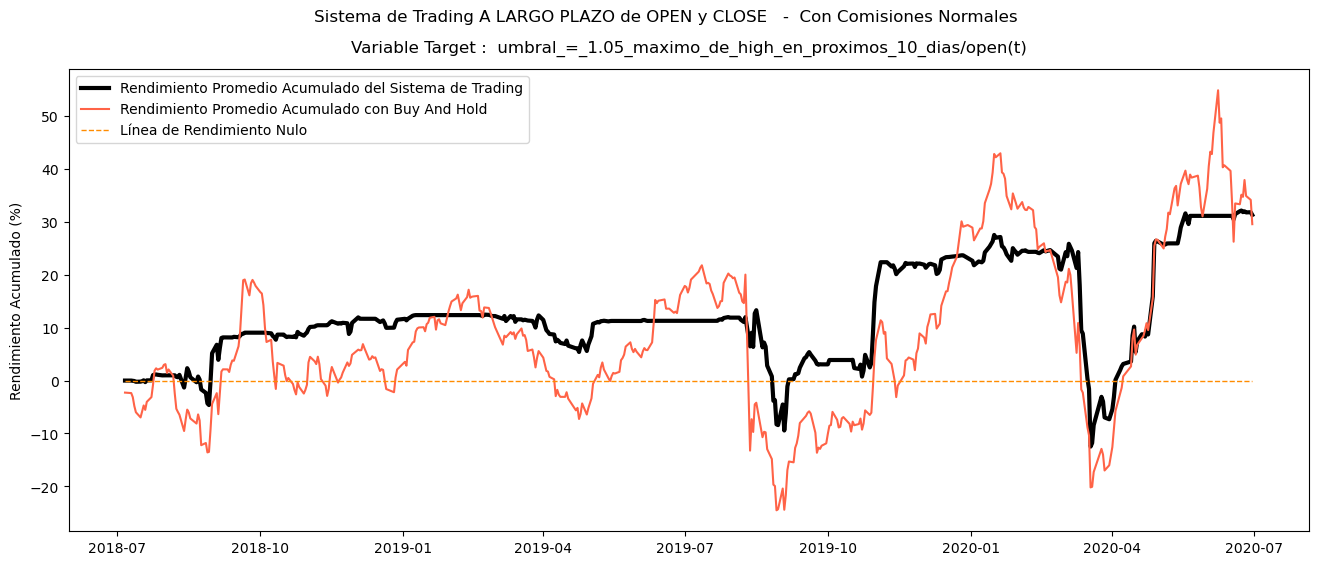

In [38]:
sistema_trading_a_largo_plazo_operando_en_Open_y_Close (data, y_test, y_pred_de_compra, variable_target_de_compra,
                                                        cantidad_de_dias_del_titulo_en_cartera = 5,
                                                        extender_periodo_de_tenencia_en_cartera = "no",
                                                        grafico_lista_de_rendimientos_individuales = "no",
                                                        grafico_rendimiento_individual_acumulado = "especificar_accion",
                                                        grafico_rendimiento_promedio_acumulado = "si",
                                                        grafico_rendimiento_individual_acumulado_Buy_And_Hold = "no",
                                                        grafico_rendimiento_promedio_acumulado_Buy_And_Hold = "si",
                                                        grafico_rendimiento_dolar_blue = "no",
                                                        grafico_rendimiento_dolar_ccl = "no",
                                                        modo_detallado_del_grafico_rendimiento_individual_acumulado = "si",
                                                        return_valores = "no")

###### Operando en OPEN y HIGH:

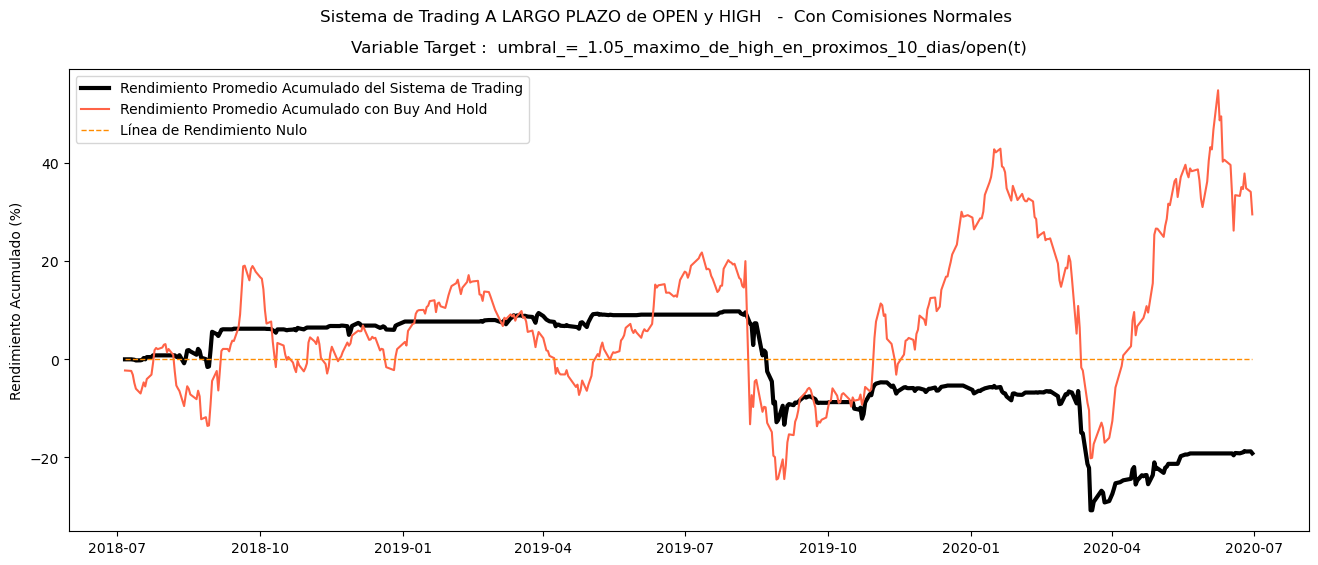

In [40]:
sistema_trading_a_largo_plazo_operando_en_Open_y_High  (data, y_test, y_pred_de_compra, variable_target_de_compra,
                                                        umbral_de_High = 1.04,
                                                        cantidad_de_dias_del_titulo_en_cartera = 5,
                                                        extender_periodo_de_tenencia_en_cartera = "no",
                                                        grafico_lista_de_rendimientos_individuales = "no",
                                                        grafico_rendimiento_individual_acumulado = "especificar_accion",
                                                        grafico_rendimiento_promedio_acumulado = "si",
                                                        grafico_rendimiento_individual_acumulado_Buy_And_Hold = "no",
                                                        grafico_rendimiento_promedio_acumulado_Buy_And_Hold = "si",
                                                        grafico_rendimiento_dolar_blue = "no",
                                                        grafico_rendimiento_dolar_ccl = "no",
                                                        modo_detallado_del_grafico_rendimiento_individual_acumulado = "no",
                                                        return_valores = "no")

#### INTRADIARIO

###### Operando en OPEN y CLOSE:

In [ ]:
sistema_trading_intradiario_operando_en_Open_y_Close (y_test, y_pred, data, variable_target_de_compra,
                                                      grafico_lista_de_rendimientos_individuales = "no",
                                                      grafico_rendimiento_individual_acumulado = "especificar_accion",
                                                      grafico_rendimiento_promedio_acumulado="si",
                                                      grafico_rendimiento_individual_acumulado_Buy_And_Hold = "no",
                                                      grafico_rendimiento_promedio_acumulado_Buy_And_Hold = "si")

###### Operando en OPEN y HIGH:

In [ ]:
sistema_trading_intradiario_operando_en_Open_y_High (y_test, y_pred, data, umbral_de_High = 1.05, variable_target_de_compra,
                                                     grafico_lista_de_rendimientos_individuales = "no",
                                                     grafico_rendimiento_individual_acumulado = "especificar_accion",
                                                     grafico_rendimiento_promedio_acumulado="si",
                                                     grafico_rendimiento_individual_acumulado_Buy_And_Hold = "no",
                                                     grafico_rendimiento_promedio_acumulado_Buy_And_Hold = "si")